## Feature selection

Why would it even be necessary to select features? To some, this idea may seem counterintuitive, but there are at least two important reasons to get rid of unimportant features. 

The first is clear to every engineer: the more data, the higher the computational complexity. 

As long as we work with toy datasets, the size of the data is not a problem, but, for real loaded production systems, hundreds of extra features will be quite tangible. 

The second reason is that some algorithms take noise (non-informative features) as a signal and overfit.

### Statistical approaches

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

#### Basado en estadísticos no supervisado

In [301]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(random_state=2)
x_data_generated.shape

(100, 20)

In [302]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 20)

In [303]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 15)

In [304]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 14)

In [305]:
# Comprueba que esta bien!

In [306]:
type(x_data_generated)

numpy.ndarray

In [307]:
x_data_generated[0]

array([-0.26623674,  1.578341  ,  0.24767631,  0.68782416, -1.84743373,
        0.9531774 , -0.34524196, -0.66518017,  0.7935246 , -0.03468537,
        0.83871299,  1.33239286,  0.45718852,  0.69619375,  0.14982795,
        0.39168286,  0.08027062, -0.17070155,  0.76586746, -2.1686185 ])

Otra opción es buscar pares de variables muy correlacionadas entre sí y eliminar una de ellas

**Cuidado: la correlación es relación lineal, pueden existir relaciones no lineales (más abajo)**

In [308]:
# HACER

# Supervisado
Correlación: con cuidado porque solo recoje relaciones lineales

In [309]:
# Ojo con esto
no_lineal = pd.DataFrame([[-2,-1,0,1,2], [4,1,0,1,4]]).T
no_lineal.columns = ["X", "y"]
no_lineal.corr()

,X,y
X,1.0,0.0
y,0.0,1.0


<Axes: xlabel='X'>

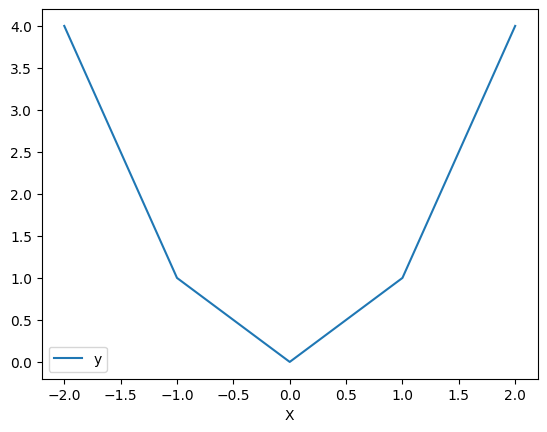

In [310]:
no_lineal.plot("X","y")

# Basado en estadísticos supervisado

# Correlación
#### Similar al anterior pero ahora solo con la variable a predecir/endógena/y

In [311]:
import pandas as pd
df = pd.DataFrame(x_data_generated, columns = ["col_{}".format(i) for i in range(1,21)])
df["y"] = y_data_generated
from matplotlib import pyplot as plt 
corr_matrix = df.corr()
corr_matrix.y.apply(lambda row: abs(row) > 0.25)

col_1     False
col_2      True
col_3      True
col_4     False
col_5     False
col_6     False
col_7     False
col_8     False
col_9     False
col_10    False
col_11    False
col_12    False
col_13    False
col_14    False
col_15    False
col_16    False
col_17    False
col_18    False
col_19    False
col_20    False
y          True
Name: y, dtype: bool

#### Más elaborado:

In [312]:
# ANOVA
import numpy as np
import pandas as pd

def calculate_ssw(df):
    # Calculate the mean of each group (column)
    group_means = df.mean()
    
    # Calculate the sum of squares within each group (SSW)
    ssw = sum(
        df.apply(lambda col: sum((col - group_means[col.name])**2))
    )
    
    return ssw

def anova_one_way(data):
    # Number of groups
    k = len(data.columns)
    # Total number of observations
    N =  len(data.values.ravel())
    # Overall mean
    # ¿La media de medias siempre funciona?
    overall_mean = data.mean().mean() #data.values.mean()
   
    # Between-group variability (SSB)
    # ¿Cómo de diferente es la media de cada columna respecto a la media total?
    SSB = (sum([len(data) * (data.mean() - overall_mean)**2])).sum()

    # Within-group variability (SSW)
    # ¿Cómo de diferente es la media de cada observación respecto a la media su columna?
    SSW =calculate_ssw(data)
    # Degrees of freedom
    df_between = k - 1
    df_within = N - k
    
    # Mean square between (MSB) and mean square within (MSW)
    MSB = SSB / df_between
    MSW = SSW / df_within
    
    # F-statistic
    F = MSB / MSW

    return F, df_between, df_within

# Ejemplo
# Para predecir a nota de los estudiantes tenemos el dato del profesor que evaluó el examen
# ¿Merece la pena introducir esa variable?
# Sólo si el profesor que evalua influye en la nota
# ESto es, si su distribución es diferente: lo vemos con ANOVA
prof1 = [8, 7, 6.1, 8, 8.2, 4.5]
prof2 = [9, 7.4, 6.4, 7, 8, 4]
prof3 = [10, 9, 9, 9.5, 9.7, 9.9]

dt = pd.DataFrame([prof1, prof2, prof3]).T
dt.columns = ["p1", "p2", "p3"]

# F = MSB / MSW
# Si F es grande: MSB >> MSW hay varinza que se explica por el profesor!
F, df_between, df_within = anova_one_way(dt)
print(f"F-statistic: {F}, Degrees of freedom (between groups): {df_between}, Degrees of freedom (within groups): {df_within}")


F-statistic: 7.515892891543065, Degrees of freedom (between groups): 2, Degrees of freedom (within groups): 15


In [313]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

'''
f_classif realiza un test ANOVA
a técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos. Esta técnica puede generalizarse también para estudiar los posibles efectos de los factores sobre la
varianza de una variable.
'''
x_data_kbest = SelectKBest(f_classif, k=10).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

In [314]:
x_data_kbest.shape

(100, 10)

In [315]:
x_data_varth.shape

(100, 14)

In [316]:
logit = LogisticRegression(solver='lbfgs', random_state=17)

In [317]:
'''
log los es la distancia, o pérdida de info para los algoritmos de clasificación. Lo suyo es minimizarla

log_loss es una métrica que se trata de minimizar
neg_log_loss trata de maximizar. Existe ya que sklearn por lo general MAXIMIZA, es por ello
que intenta mantener sus funciones de maximiazación sin cambiar el código. Simplemente
le da la vuelta a la métrica.
'''
cross_val_score(logit, x_data_generated, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.3822531058548313

In [318]:
# Mejora
cross_val_score(logit, x_data_kbest, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.3460066141004937

In [319]:
# Mejora
cross_val_score(logit, x_data_varth, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.3665468684114632

We can see that our selected features have improved the quality of the classifier. Of course, this example is purely artificial; however, it is worth using for real problems.

### Selection by modeling

Another approach is to use some baseline model for feature evaluation because the model will clearly show the importance of the features. 

Two types of models are usually used: some “wooden” composition such as [Random Forest](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7) or a linear model with Lasso regularization so that it is prone to nullify weights of weak features. 

The logic is intuitive: if features are clearly useless in a simple model, there is no need to drag them to a more complex one.

#### Supervisado intrinseco

In [320]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification(random_state=3)
logit = LogisticRegression(solver='lbfgs', random_state=17)
rf = RandomForestClassifier(n_estimators=10, random_state=17)

# Se usa la media como umbral selector
# La idea es tomar solo aquellas columnas que el random forest considera "importantes" 
# "Importantes": están por encima de la media de las importancias (se puede tunear)
# Con esas variables hace la regresión logística pues asume que el resto no aportan casi poder predictivo
pipe = make_pipeline(SelectFromModel(estimator=rf),
                     logit)

print(cross_val_score(logit, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())

-0.4296975743731263
-0.3989302697641607
-0.38656494339649383


# Reconstruimos el proceso

In [321]:
# Creamos el dataset
dt = pd.DataFrame(x_data_generated, columns=["col_"+str(x) for x in range(x_data_generated.shape[1])])

In [322]:
# Entrenamos el Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=17)
rf.fit(dt, y_data_generated)

RandomForestClassifier(n_estimators=10, random_state=17)

In [323]:
# Solo queremos aquellos cuya "importancia" esté por encima de la media
rf.feature_importances_.mean()

0.049999999999999996

In [324]:
rf.feature_names_in_[rf.feature_importances_>=rf.feature_importances_.mean()]

array(['col_0', 'col_15', 'col_16', 'col_17', 'col_18'], dtype=object)

In [325]:
logit = LogisticRegression(solver='lbfgs', random_state=17)
logit.fit(dt[rf.feature_names_in_[rf.feature_importances_>=rf.feature_importances_.mean()]], y_data_generated)

LogisticRegression(random_state=17)

In [326]:
# Si todo está bien, debemos llegar a estos coeficientes
logit.coef_

array([[ 0.22809565,  1.49784072, -0.41987508,  1.54380596, -0.3799787 ]])

In [327]:
# Ahora en el pipeline
logit_pipe = LogisticRegression(solver='lbfgs', random_state=17)
rf_pipe = RandomForestClassifier(n_estimators=10, random_state=17)

# Se usa la media como umbral selector
pipe = make_pipeline(SelectFromModel(estimator=rf_pipe),
                     logit_pipe)

pipe.fit(dt, y_data_generated)
pipe.score(dt, y_data_generated)

0.86

In [328]:
# Menos mal que nos ha salido!
logit.coef_ == pipe[1].coef_

array([[ True,  True,  True,  True,  True]])

In [329]:
# Podemos probar que las probabilidades en la predicción, accuracy, recall, precision... coinciden!

We must not forget that this is not a silver bullet again - it can make the performance worse.

In [330]:
x_data_generated, y_data_generated = make_classification(random_state=42)
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(SelectFromModel(estimator=rf),
                      logit)

pipe2 = make_pipeline(logit)

print('LR + selection: ', cross_val_score(pipe1, x_data, y_data, 
                                          scoring='neg_log_loss', cv=5).mean())
print('LR: ', cross_val_score(pipe2, x_data, y_data, 
                              scoring='neg_log_loss', cv=5).mean())
print('RF: ', cross_val_score(rf, x_data, y_data, 
                              scoring='neg_log_loss', cv=5).mean())

LR + selection:  -0.12106171085608741
LR:  -0.0958832351974094
RF:  -0.19951849160449495


#### Supervisado wrapper

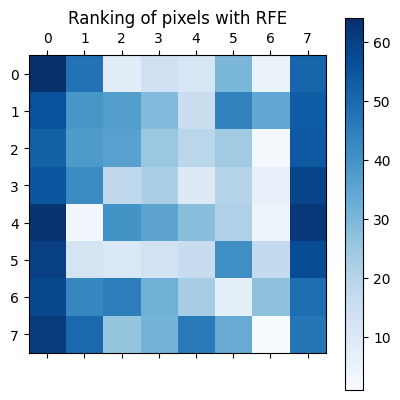

In [331]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

'''
Se escoge un estimador y un numero n de features. Se lanza el estimador con TODAS
las features y se calcula el "feature importance" de estimador. La peor feature se
elimina y se tira otro modelo con una feature menos, asi hasta alcanzar n
https://machinelearningmastery.com/rfe-feature-selection-in-python/
'''
# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
lr = LogisticRegression(random_state=22, max_iter=5000)

rfe = RFE(estimator=lr,
          n_features_to_select=1,
          step=1) # Features a eliminar en cada paso. 1 por defecto

rfe.fit(X, y)
'''
Ranking del 1 al 64, que son todos los pixeles.
rfe.support_ te da una mascara para filtrar luego las columnas
'''
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

In [332]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1204)

In [436]:
lr = LogisticRegression(random_state=22, max_iter=5000)
rfe = RFE(estimator=lr, n_features_to_select=59, step=5)
rfe.fit_transform(X_train, y_train)
rfe.score(X_test,y_test)

0.9555555555555556

In [439]:
rfe.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

In [440]:
lr_2 = LogisticRegression(random_state=22, max_iter=5000)
lr_2.fit(X_train, y_train)
coef_dt = pd.DataFrame(lr_2.coef_)

<Axes: ylabel='Feature'>

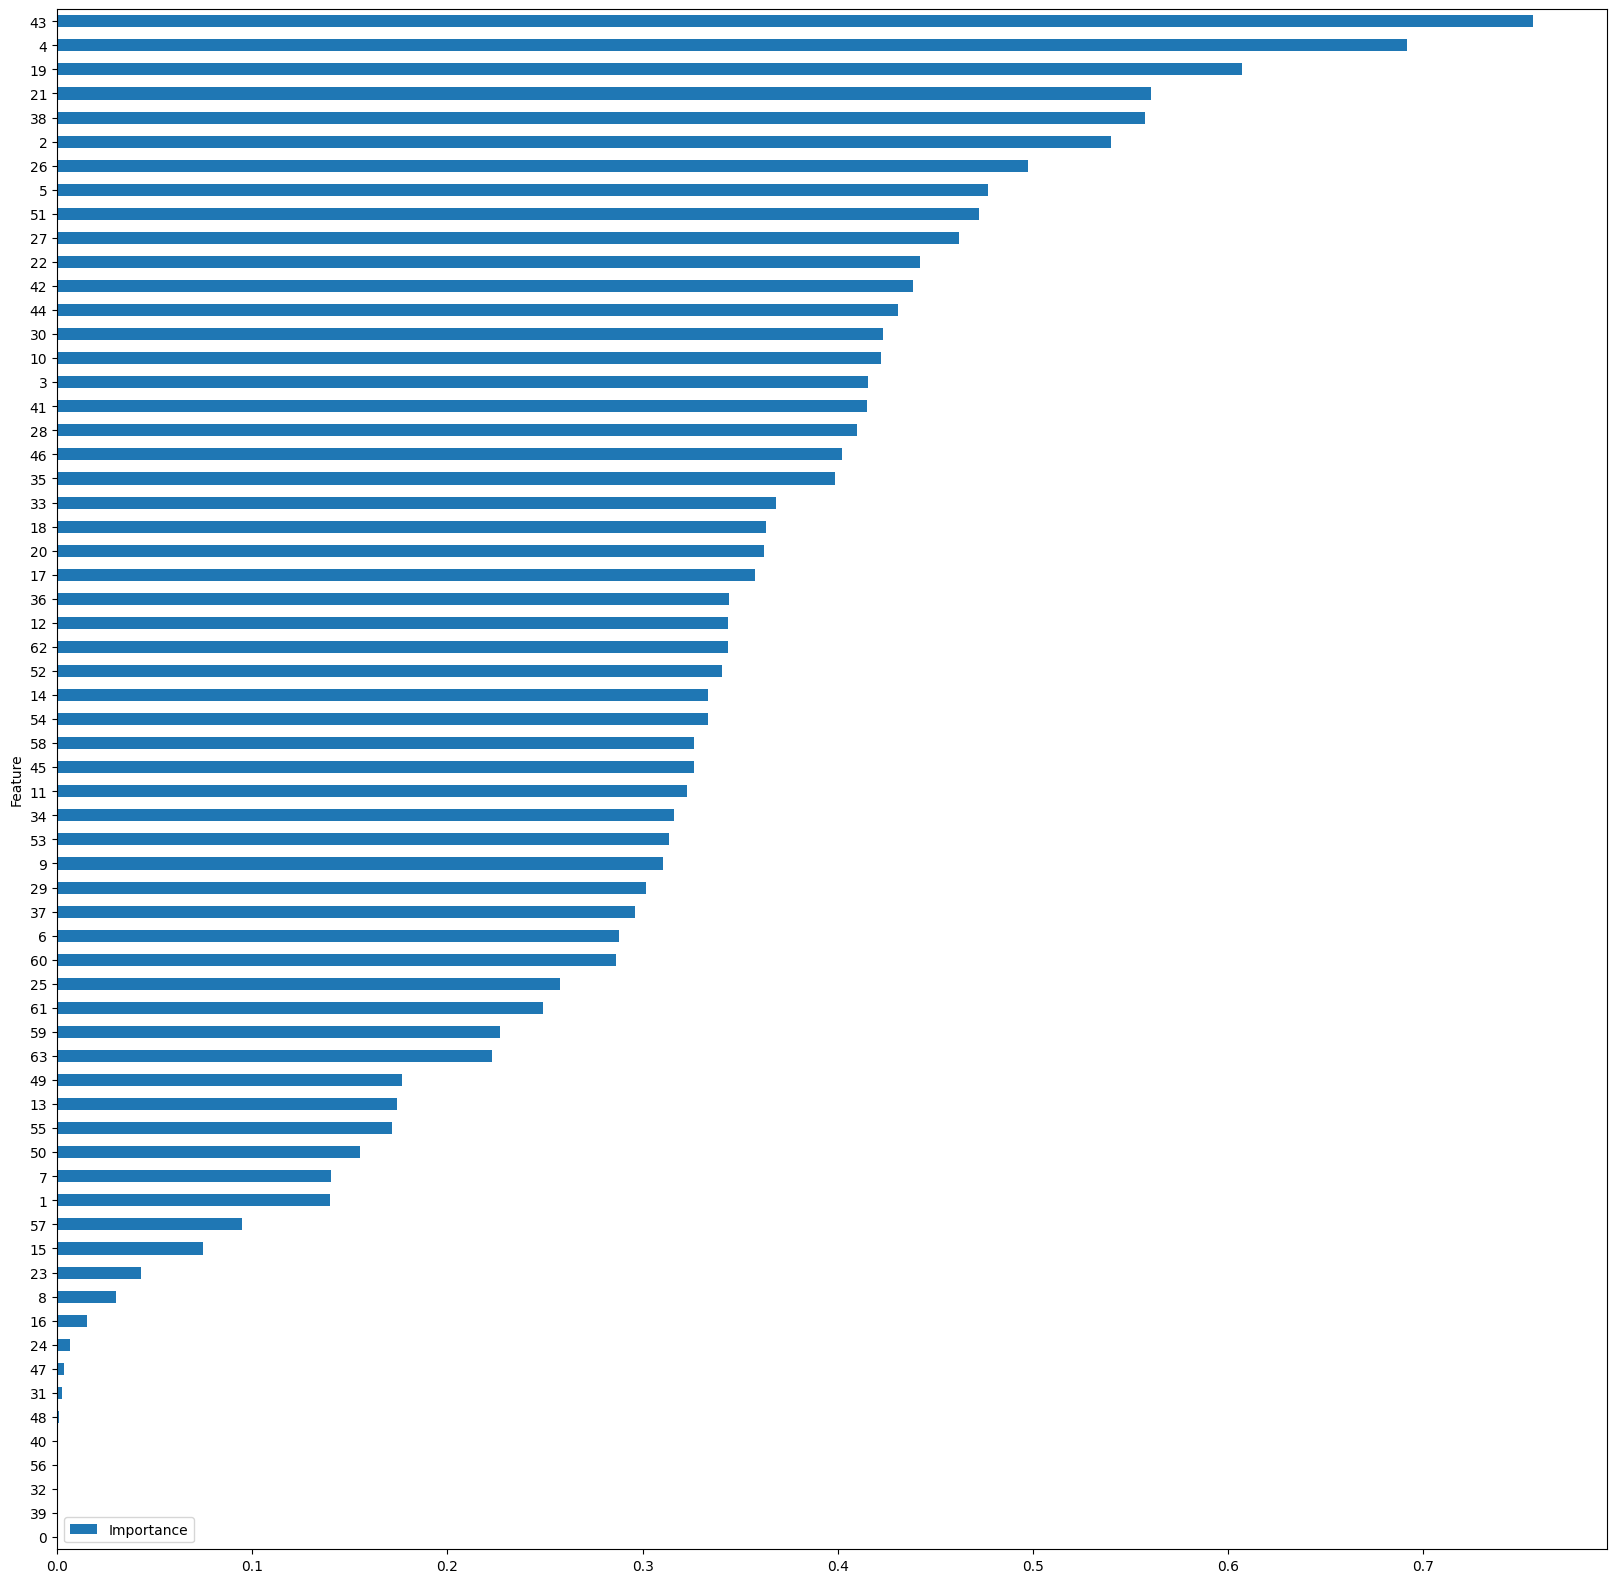

In [442]:

avg_importance = np.max(np.abs(lr_2.coef_), axis=0)
feature_importance = pd.DataFrame({'Feature': pd.DataFrame(X_train).columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20, 20))

In [449]:
lr_2.fit(X_train_dt.drop(columns=[0, 39, 32, 40, 56]), y_train)
lr_2.score(pd.DataFrame(X_test).drop(columns=[0, 39, 32, 40,56]), y_test)

0.9555555555555556

In [451]:
lr_2.predict_proba(pd.DataFrame(X_test).drop(columns=[0, 39, 32, 40,56])[:1])

array([[1.83241583e-11, 6.41945467e-12, 1.22948583e-11, 1.12949164e-07,
        2.49118129e-08, 2.61668915e-09, 1.22024739e-10, 1.15524395e-11,
        9.99512548e-01, 4.87311629e-04]])

In [452]:
rfe.predict_proba(X_test[:1])

array([[1.83241583e-11, 6.41945467e-12, 1.22948583e-11, 1.12949164e-07,
        2.49118129e-08, 2.61668915e-09, 1.22024739e-10, 1.15524395e-11,
        9.99512548e-01, 4.87311629e-04]])

In [453]:
lr_2.predict_proba(pd.DataFrame(X_test).drop(columns=[0, 39, 32, 40,56])[:1]) == rfe.predict_proba(X_test[:1])

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

#### Feature Selection with PCA, choosing the right number of features/dimensions

In [ ]:
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

import numpy as np

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]


In [ ]:
X_train.shape

(60000, 784)

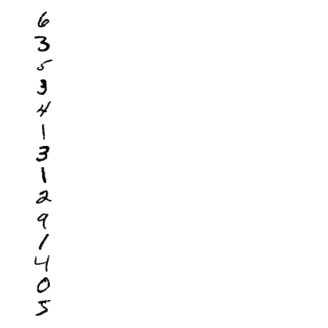

In [ ]:

plt.figure(figsize=(7, 4))
row = 1
num_images = 14
for col in range(num_images):
    plt.imshow(X_train[col].reshape(28, 28), cmap="binary",
               vmin=0, vmax=255,  extent=(row, row + 1, col, col + 1))
    plt.axis([0, num_images,0, num_images])
    plt.axis("off")


In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

154

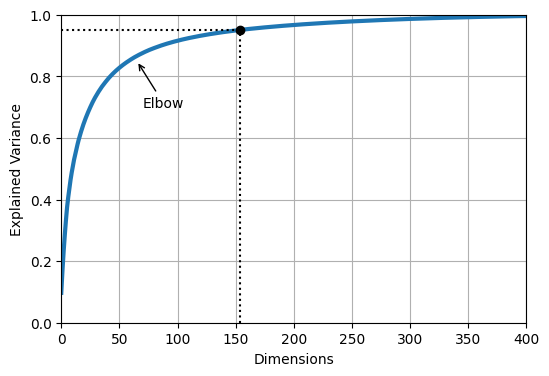

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [462]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [459]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), LogisticRegression(random_state=33))
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

c:\Users\Jonatan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Jonatan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=33))]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [461]:
grid_search.best_params_

{'pca__n_components': 34}